### Preparation

In [1]:
!git clone https://github.com/ashkamath/mdetr.git

Cloning into 'mdetr'...
remote: Enumerating objects: 192, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 192 (delta 52), reused 26 (delta 26), pack-reused 84 (from 1)
Receiving objects: 100% (192/192), 9.63 MiB | 7.69 MiB/s, done.
Resolving deltas: 100% (81/81), done.


In [2]:
%cd mdetr/

/home2/sudarshannikhil/Multimodal-XAI/DIME/mdetr


In [3]:
!pip install git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI&egg=pycocotools
!pip install git+https://github.com/cocodataset/panopticapi.git#egg=panopticapi

  Cloning https://github.com/cocodataset/panopticapi.git to /tmp/pip-install-brv0qy6l/panopticapi_17517bf7ff574c30b7b91fb572552136
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/panopticapi.git /tmp/pip-install-brv0qy6l/panopticapi_17517bf7ff574c30b7b91fb572552136
  Resolved https://github.com/cocodataset/panopticapi.git to commit 7bb4655548f98f3fedc07bf37e9040a992b054b0
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


In [4]:
%%writefile requirements.txt
cython==0.29.27
lime
ipywidgets
onnx==1.10.2
onnxruntime==1.10.0
opencv-python==4.5.5.64
packaging==21.3
prettytable==3.0.0
pycocotools
scipy==1.4.1
submitit==1.4.1
timm==0.5.4
torch==1.7.0
torchvision==0.8.1
transformers==4.6
tqdm==4.62.3
xmltodict==0.12.0

Overwriting requirements.txt


In [5]:
!pip install -r requirements.txt

In [6]:
import json
with open('configs/clevr.json', 'r') as f:
  data = json.load(f)

data['clevr_img_path'] = 'ssd_scratch/sn/CLEVR_v1.0/images'
data['clevr_ann_path'] = 'ssd_scratch/sn/clevr_annotations/full'

with open('configs/clevr.json', 'w') as f:
    json.dump(data, f)

In [7]:
%env CUBLAS_WORKSPACE_CONFIG=:16:8

env: CUBLAS_WORKSPACE_CONFIG=:16:8


### Create Dataset

In [8]:
import io
import json
import numpy as np
import os
from pathlib import Path
from PIL import Image
import pickle
from transformers import RobertaTokenizerFast
import torch
import torch.utils.data
import torchvision

from datasets.coco import ConvertCocoPolysToMask, create_positive_map
import datasets.transforms as T

ALL_ATTRIBUTES = [
    "small",
    "large",
    "gray",
    "red",
    "blue",
    "green",
    "brown",
    "purple",
    "cyan",
    "yellow",
    "cube",
    "sphere",
    "cylinder",
    "rubber",
    "metal",
]

def _encode_answer(target, answer):
    if answer in ["yes", "no"]:
        target["answer_type"] = torch.as_tensor(0, dtype=torch.long)
        target["answer_binary"] = torch.as_tensor(0.0 if answer == "no" else 1.0)
        target["answer_attr"] = torch.as_tensor(-100, dtype=torch.long)
        target["answer_reg"] = torch.as_tensor(-100, dtype=torch.long)
    elif answer in ALL_ATTRIBUTES:
        target["answer_type"] = torch.as_tensor(1, dtype=torch.long)
        target["answer_binary"] = torch.as_tensor(0.0)
        target["answer_attr"] = torch.as_tensor(ALL_ATTRIBUTES.index(answer), dtype=torch.long)
        target["answer_reg"] = torch.as_tensor(-100, dtype=torch.long)
    else:
        target["answer_type"] = torch.as_tensor(2, dtype=torch.long)
        target["answer_binary"] = torch.as_tensor(0.0)
        target["answer_attr"] = torch.as_tensor(-100, dtype=torch.long)
        target["answer_reg"] = torch.as_tensor(int(answer), dtype=torch.long)
    return target

class ClevrDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, ann_file, transforms, return_masks, return_tokens, tokenizer, do_qa):
        super(ClevrDetection, self).__init__(img_folder, ann_file)
        self._transforms = transforms
        self.prepare = ConvertCocoPolysToMask(return_masks, return_tokens)
        self.tokenizer = tokenizer
        self.return_tokens = return_tokens
        self.do_qa = do_qa

    def __getitem__(self, idx):
        img, target = super(ClevrDetection, self).__getitem__(idx)
        image_id = self.ids[idx]
        img_data = self.coco.loadImgs(image_id)[0]
        caption = img_data["caption"] if "caption" in img_data else None
        target = {"image_id": image_id, "annotations": target, "caption": caption}
        img, target = self.prepare(img, target)
        if self.do_qa:
            answer = img_data["answer"]
            target = _encode_answer(target, answer)

        if self.return_tokens:
            assert len(target["boxes"]) == len(target["tokens_positive"])
            tokenized = self.tokenizer(caption, return_tensors="pt")
            # construct a map such that positive_map[i,j] = True iff box i is associated to token j
            target["positive_map"] = create_positive_map(tokenized, target["tokens_positive"])

        if self._transforms is not None:
            img, target = self._transforms(img, target)
        return img, target

def make_clevr_transforms(image_set, cautious=False):

    normalize = T.Compose([T.ToTensor(), T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    scales = [256, 288, 320, 352, 384]

    if image_set == "train":
        horizontal = [] if cautious else [T.RandomHorizontalFlip()]
        return T.Compose(
            horizontal
            + [
                T.RandomSelect(
                    T.RandomResize(scales, max_size=512),
                    T.Compose(
                        [
                            T.RandomResize([320, 352, 384]),
                            T.RandomSizeCrop(256, 512, respect_boxes=cautious),
                            T.RandomResize(scales, max_size=512),
                        ]
                    ),
                ),
                normalize,
            ]
        )

    if image_set == "val":
        return T.Compose(
            [
                # T.RandomResize([480], max_size=1333),
                normalize,
            ]
        )

    raise ValueError(f"unknown {image_set}")

In [9]:
tokenizer = RobertaTokenizerFast.from_pretrained('distilroberta-base')

img_dir = '/ssd_scratch/sn/CLEVR_v1.0/images/val'
ann_file = '/ssd_scratch/sn/clevr_annotations/full/val.json'
image_set = 'val'
dataset = ClevrDetection(
    img_dir,
    ann_file,
    transforms=make_clevr_transforms(image_set, cautious=True),
    return_masks=False,
    return_tokens=True,
    tokenizer=tokenizer,
    do_qa=1,
)

loading annotations into memory...
Done (t=3.20s)
creating index...
index created!


### Get MDETR Model

In [10]:
import argparse
from collections import namedtuple
from copy import deepcopy
import datetime
from functools import partial
import json
import numpy as np
import os
from pathlib import Path
import random
import time
import torch
import torch.utils
from torch.utils.data import ConcatDataset, DataLoader, DistributedSampler

from datasets import build_dataset, get_coco_api_from_dataset
from datasets.clevrref import ClevrRefEvaluator
from datasets.coco_eval import CocoEvaluator
from datasets.flickr_eval import FlickrEvaluator
from datasets.phrasecut_eval import PhrasecutEvaluator
from datasets.refexp import RefExpEvaluator
from engine import evaluate, train_one_epoch
from models import build_model
from models.postprocessors import build_postprocessors
import util.dist as dist
import util.misc as utils

def get_args_parser():
    parser = argparse.ArgumentParser("Set transformer detector", add_help=False)
    parser.add_argument("--run_name", default="", type=str)

    # Dataset specific
    parser.add_argument("--dataset_config", default=None, required=True)
    parser.add_argument("--do_qa", action="store_true", help="Whether to do question answering")
    parser.add_argument(
        "--predict_final",
        action="store_true",
        help="If true, will predict if a given box is in the actual referred set. Useful for CLEVR-Ref+ only currently.",
    )
    parser.add_argument("--no_detection", action="store_true", help="Whether to train the detector")
    parser.add_argument(
        "--split_qa_heads", action="store_true", help="Whether to use a separate head per question type in vqa"
    )
    parser.add_argument(
        "--combine_datasets", nargs="+", help="List of datasets to combine for training", default=["flickr"]
    )
    parser.add_argument(
        "--combine_datasets_val", nargs="+", help="List of datasets to combine for eval", default=["flickr"]
    )

    parser.add_argument("--coco_path", type=str, default="")
    parser.add_argument("--vg_img_path", type=str, default="")
    parser.add_argument("--vg_ann_path", type=str, default="")
    parser.add_argument("--clevr_img_path", type=str, default="")
    parser.add_argument("--clevr_ann_path", type=str, default="")
    parser.add_argument("--phrasecut_ann_path", type=str, default="")
    parser.add_argument(
        "--phrasecut_orig_ann_path",
        type=str,
        default="",
    )
    parser.add_argument("--modulated_lvis_ann_path", type=str, default="")

    # Training hyper-parameters
    parser.add_argument("--lr", default=1e-4, type=float)
    parser.add_argument("--lr_backbone", default=1e-5, type=float)
    parser.add_argument("--text_encoder_lr", default=5e-5, type=float)
    parser.add_argument("--batch_size", default=2, type=int)
    parser.add_argument("--weight_decay", default=1e-4, type=float)
    parser.add_argument("--epochs", default=40, type=int)
    parser.add_argument("--lr_drop", default=35, type=int)
    parser.add_argument(
        "--epoch_chunks",
        default=-1,
        type=int,
        help="If greater than 0, will split the training set into chunks and validate/checkpoint after each chunk",
    )
    parser.add_argument("--optimizer", default="adam", type=str)
    parser.add_argument("--clip_max_norm", default=0.1, type=float, help="gradient clipping max norm")
    parser.add_argument(
        "--eval_skip",
        default=1,
        type=int,
        help='do evaluation every "eval_skip" frames',
    )

    parser.add_argument(
        "--schedule",
        default="linear_with_warmup",
        type=str,
        choices=("step", "multistep", "linear_with_warmup", "all_linear_with_warmup"),
    )
    parser.add_argument("--ema", action="store_true")
    parser.add_argument("--ema_decay", type=float, default=0.9998)
    parser.add_argument("--fraction_warmup_steps", default=0.01, type=float, help="Fraction of total number of steps")

    # Model parameters
    parser.add_argument(
        "--frozen_weights",
        type=str,
        default=None,
        help="Path to the pretrained model. If set, only the mask head will be trained",
    )

    parser.add_argument(
        "--freeze_text_encoder", action="store_true", help="Whether to freeze the weights of the text encoder"
    )

    parser.add_argument(
        "--text_encoder_type",
        default="roberta-base",
        choices=("roberta-base", "distilroberta-base", "roberta-large"),
    )

    # Backbone
    parser.add_argument(
        "--backbone",
        default="resnet101",
        type=str,
        help="Name of the convolutional backbone to use such as resnet50 resnet101 timm_tf_efficientnet_b3_ns",
    )
    parser.add_argument(
        "--dilation",
        action="store_true",
        help="If true, we replace stride with dilation in the last convolutional block (DC5)",
    )
    parser.add_argument(
        "--position_embedding",
        default="sine",
        type=str,
        choices=("sine", "learned"),
        help="Type of positional embedding to use on top of the image features",
    )

    # Transformer
    parser.add_argument(
        "--enc_layers",
        default=6,
        type=int,
        help="Number of encoding layers in the transformer",
    )
    parser.add_argument(
        "--dec_layers",
        default=6,
        type=int,
        help="Number of decoding layers in the transformer",
    )
    parser.add_argument(
        "--dim_feedforward",
        default=2048,
        type=int,
        help="Intermediate size of the feedforward layers in the transformer blocks",
    )
    parser.add_argument(
        "--hidden_dim",
        default=256,
        type=int,
        help="Size of the embeddings (dimension of the transformer)",
    )
    parser.add_argument("--dropout", default=0.1, type=float, help="Dropout applied in the transformer")
    parser.add_argument(
        "--nheads",
        default=8,
        type=int,
        help="Number of attention heads inside the transformer's attentions",
    )
    parser.add_argument("--num_queries", default=100, type=int, help="Number of query slots")
    parser.add_argument("--pre_norm", action="store_true")
    parser.add_argument(
        "--no_pass_pos_and_query",
        dest="pass_pos_and_query",
        action="store_false",
        help="Disables passing the positional encodings to each attention layers",
    )

    # Segmentation
    parser.add_argument(
        "--mask_model",
        default="none",
        type=str,
        choices=("none", "smallconv", "v2"),
        help="Segmentation head to be used (if None, segmentation will not be trained)",
    )
    parser.add_argument("--remove_difficult", action="store_true")
    parser.add_argument("--masks", action="store_true")

    # Loss
    parser.add_argument(
        "--no_aux_loss",
        dest="aux_loss",
        action="store_false",
        help="Disables auxiliary decoding losses (loss at each layer)",
    )
    parser.add_argument(
        "--set_loss",
        default="hungarian",
        type=str,
        choices=("sequential", "hungarian", "lexicographical"),
        help="Type of matching to perform in the loss",
    )

    parser.add_argument("--contrastive_loss", action="store_true", help="Whether to add contrastive loss")
    parser.add_argument(
        "--no_contrastive_align_loss",
        dest="contrastive_align_loss",
        action="store_false",
        help="Whether to add contrastive alignment loss",
    )

    parser.add_argument(
        "--contrastive_loss_hdim",
        type=int,
        default=64,
        help="Projection head output size before computing normalized temperature-scaled cross entropy loss",
    )

    parser.add_argument(
        "--temperature_NCE", type=float, default=0.07, help="Temperature in the  temperature-scaled cross entropy loss"
    )

    # * Matcher
    parser.add_argument(
        "--set_cost_class",
        default=1,
        type=float,
        help="Class coefficient in the matching cost",
    )
    parser.add_argument(
        "--set_cost_bbox",
        default=5,
        type=float,
        help="L1 box coefficient in the matching cost",
    )
    parser.add_argument(
        "--set_cost_giou",
        default=2,
        type=float,
        help="giou box coefficient in the matching cost",
    )
    # Loss coefficients
    parser.add_argument("--ce_loss_coef", default=1, type=float)
    parser.add_argument("--mask_loss_coef", default=1, type=float)
    parser.add_argument("--dice_loss_coef", default=1, type=float)
    parser.add_argument("--bbox_loss_coef", default=5, type=float)
    parser.add_argument("--giou_loss_coef", default=2, type=float)
    parser.add_argument("--qa_loss_coef", default=1, type=float)
    parser.add_argument(
        "--eos_coef",
        default=0.1,
        type=float,
        help="Relative classification weight of the no-object class",
    )
    parser.add_argument("--contrastive_loss_coef", default=0.1, type=float)
    parser.add_argument("--contrastive_align_loss_coef", default=1, type=float)

    # Run specific

    parser.add_argument("--test", action="store_true", help="Whether to run evaluation on val or test set")
    parser.add_argument("--test_type", type=str, default="test", choices=("testA", "testB", "test"))
    parser.add_argument("--output-dir", default="", help="path where to save, empty for no saving")
    parser.add_argument("--device", default="cuda", help="device to use for training / testing")
    parser.add_argument("--seed", default=42, type=int)
    parser.add_argument("--resume", default="", help="resume from checkpoint")
    parser.add_argument("--load", default="", help="resume from checkpoint")
    parser.add_argument("--start-epoch", default=0, type=int, metavar="N", help="start epoch")
    parser.add_argument("--eval", action="store_true", help="Only run evaluation")
    parser.add_argument("--num_workers", default=5, type=int)

    # Distributed training parameters
    parser.add_argument("--world-size", default=1, type=int, help="number of distributed processes")
    parser.add_argument("--dist-url", default="env://", help="url used to set up distributed training")
    return parser

parser = argparse.ArgumentParser("DETR training and evaluation script", parents=[get_args_parser()])
args = parser.parse_args(['--batch_size', '1', '--dataset_config', 'configs/clevr.json', '--num_queries' ,'25',
                          '--text_encoder_type' ,'distilroberta-base', '--backbone' ,'resnet18',
                          '--resume' ,'https://zenodo.org/record/4721981/files/clevr_checkpoint.pth',
                          '--eval'])
d = vars(args)
with open(args.dataset_config, "r") as f:
    cfg = json.load(f)
    d.update(cfg)
print(args)    
model, criterion, contrastive_criterion, qa_criterion, weight_dict = build_model(args)
checkpoint = torch.hub.load_state_dict_from_url(args.resume, map_location="cpu", check_hash=True)
model.load_state_dict(checkpoint["model"])
model.cuda()
model.eval()

Namespace(aux_loss=True, backbone='resnet18', batch_size=1, bbox_loss_coef=5, ce_loss_coef=1, clevr_ann_path='ssd_scratch/sn/clevr_annotations/full', clevr_img_path='ssd_scratch/sn/CLEVR_v1.0/images', clevr_variant='normal', clip_max_norm=0.1, coco_path='', combine_datasets=['clevr'], combine_datasets_val=['clevr'], contrastive_align_loss=True, contrastive_align_loss_coef=1, contrastive_loss=False, contrastive_loss_coef=0.1, contrastive_loss_hdim=64, dataset_config='configs/clevr.json', dec_layers=6, device='cuda', dice_loss_coef=1, dilation=False, dim_feedforward=2048, dist_url='env://', do_qa=1, dropout=0.1, ema=False, ema_decay=0.9998, enc_layers=6, eos_coef=0.1, epoch_chunks=-1, epochs=40, eval=True, eval_skip=1, fraction_warmup_steps=0.01, freeze_text_encoder=False, frozen_weights=None, giou_loss_coef=2, hidden_dim=256, load='', lr=0.0001, lr_backbone=1e-05, lr_drop=35, mask_loss_coef=1, mask_model='none', masks=False, modulated_lvis_ann_path='', nheads=8, no_detection=False, num_

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Downloading: "https://zenodo.org/record/4721981/files/clevr_checkpoint.pth" to /home2/sudarshannikhil/.cache/torch/hub/checkpoints/clevr_checkpoint.pth


  0%|          | 0.00/425M [00:00<?, ?B/s]

MDETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
      

### Show Example Prediction

In [11]:
ALL_ATTRIBUTES = [
    "small",
    "large",
    "gray",
    "red",
    "blue",
    "green",
    "brown",
    "purple",
    "cyan",
    "yellow",
    "cube",
    "sphere",
    "cylinder",
    "rubber",
    "metal",
]

class_names = ["no", "yes", "small", "large", "gray", "red", "blue", "green", "brown", "purple", "cyan", "yellow", "cube", "sphere", "cylinder", "rubber",
               "metal", 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [12]:
with torch.no_grad():
    sample = dataset[5]
    samples = torch.unsqueeze(sample[0], 0).cuda()
    captions = [sample[1]['caption']]
    memory_cache = model(samples, captions, encode_and_save=True)
    outputs = model(samples, captions, encode_and_save=False, memory_cache=memory_cache)
    print('true_answer_type:', sample[1]['answer_type'])
    print('true_answer_bin:', sample[1]['answer_binary'])
    print('true_answer_attr:', sample[1]['answer_attr'])
    print('true_answer_reg:', sample[1]['answer_reg'])
    print('---------------')
    print('pred_answer_type: ', outputs["pred_answer_type"].argmax(-1))
    print('pred_answer_bin: ', int(outputs["pred_answer_binary"].sigmoid() > 0.5))
    print('pred_answer_attr: ', outputs["pred_answer_attr"].argmax(-1))
    print('pred_answer_reg: ', outputs["pred_answer_reg"].argmax(-1))

true_answer_type: tensor(2)
true_answer_bin: tensor(0.)
true_answer_attr: tensor(-100)
true_answer_reg: tensor(2)
---------------
pred_answer_type:  tensor([2], device='cuda:0')
pred_answer_bin:  1
pred_answer_attr:  tensor([1], device='cuda:0')
pred_answer_reg:  tensor([2], device='cuda:0')


In [13]:
def pred_answer(outputs):
    idx = 0
    ans_type = int(outputs["pred_answer_type"].argmax(-1))
    if ans_type == 0:
        idx = int(outputs["pred_answer_binary"].sigmoid() > 0.5)
    elif ans_type == 1:
        idx = int(outputs["pred_answer_attr"].argmax(-1)) + 2
    else:
        idx = int(outputs["pred_answer_reg"].argmax(-1)) + 17
    return class_names[idx]

In [14]:
pred_answer(outputs)

2

### LIME

In [15]:
!mkdir datasets/lime_results

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [16]:
%%writefile limee.py
"""
Implementation of a wrapper around LIME.

Handles implementation of the LIME (Local Interpretable Model-Agnostic Explanations)
wrapper for the analysis of how important various parts of input are. Current implementation
supports unimodal explanations with specified type for one sample, keeping other 
inputs constant.
"""

from lime.lime_image import LimeImageExplainer
from lime.lime_text import LimeTextExplainer
import numpy as np
from typing import Callable, Dict

class Lime:
    """Implementation of wrapper around LIME (Local Interpretable Model-Agnostic Explanations)."""

    @classmethod
    def explain_image_instance(
        cls,
        predictor_fn: Callable,
        input_arr: np.ndarray,
        init_params: Dict = {},
        explanation_params: Dict = {},
    ):
        """Explain image instance.

        Args:
            predictor_fn: Predictor function which takes in a batch of inputs (not single input).
            input_arr: Input image as an array without a batch dimension.
            init_params: Initialization parameters for LIME Explainer.
            explanation_params: Parameters for LIME Explainer.

        Returns:
            lime.lime_image.ImageExplanation:
                Explanation of the image with given arguments
        """

        # Create LIME explainer
        lime_explainer = LimeImageExplainer(**init_params)

        # Run LIME explainer
        exp = lime_explainer.explain_instance(
            input_arr, predictor_fn, **explanation_params
        )

        return exp

    @classmethod
    def explain_text_instance(
        cls,
        predictor_fn: Callable,
        text: str,
        init_params: Dict = {},
        explanation_params: Dict = {},
    ):
        """Explain text instance.

        Args:
            predictor_fn: Predictor function which takes in a batch of inputs (not single input).
            text: Input text as a string.
            init_params: Initialization parameters for LIME Explainer.
            explanation_params: Parameters for LIME Explainer.

        Returns:
            lime.lime_text.TextExplanation:
                Explanation of the text with given arguments
        """

        # Create LIME explainer
        lime_explainer = LimeTextExplainer(**init_params)

        # Run LIME explainer
        exp = lime_explainer.explain_instance(text, predictor_fn, **explanation_params)

        return exp

Writing limee.py


In [17]:
from limee import Lime

In [18]:
with open('/ssd_scratch/sn/CLEVR_v1.0/questions/CLEVR_val_questions.json') as f:
    q = json.load(f)

In [19]:
import cv2
import matplotlib.pyplot as plt
import PIL
import requests

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [20]:
idx = 12000
example = dataset[idx]
correctansweridx = 0
os.mkdir(f'datasets/lime_results/question_{idx:06d}')

In [21]:
info = example[1]
question = info['caption']
image_id = q["questions"][idx]['image_index']
answer_type = info['answer_type']
answer_bin = info['answer_binary']
answer_attr = info['answer_attr']
answer_reg = info['answer_reg']

if answer_type == 0:
    ans = int(answer_bin)
    if ans:
        correctansweridx = 1
    else:
        correctansweridx = 0      
elif answer_type == 1:
    correctansweridx = int(answer_attr + 2)
elif answer_type == 2:
    correctansweridx = int(answer_reg + 17)

samples = example[0].unsqueeze(0).cuda()
captions = [question]
memory_cache = model(samples, captions, encode_and_save=True)
outputs = model(samples, captions, encode_and_save=False, memory_cache=memory_cache)
print(question)
print('answer: ', class_names[correctansweridx])
print('pred_answer: ', pred_answer(outputs))    

question_info = {'question': question, 'answer': class_names[correctansweridx], 'pred_answer': pred_answer(outputs)}
with open(f'datasets/lime_results/question_{idx:06d}/question_info.json', "w") as outfile:
    json.dump(question_info, outfile)

There is another object that is the same shape as the gray shiny object; what is its color?
answer:  purple
pred_answer:  purple


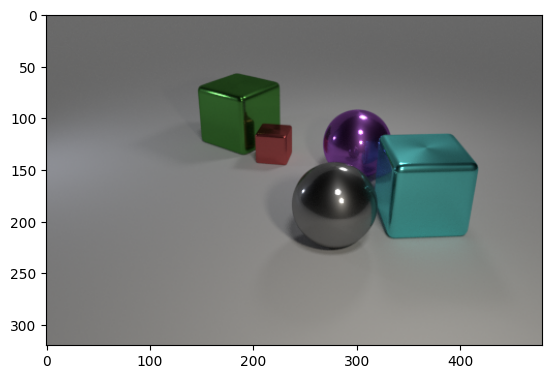

In [22]:
image = np.asarray(PIL.Image.open(f'/ssd_scratch/sn/CLEVR_v1.0/images/val/CLEVR_val_{image_id:06d}.png'))
image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
plt.imshow(image)
Image.fromarray(image).save(f'datasets/lime_results/question_{idx:06d}/orig.png')

### Running LIME on Image Modality

In [23]:
!mkdir datasets/tmp

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [24]:
from skimage.segmentation import mark_boundaries

In [25]:
import copy
import datasets.transforms as T
import torch.nn.functional as F

def make_clevr_transforms(cautious=False):
    normalize = T.Compose([T.ToTensor(), T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    scales = [256, 288, 320, 352, 384]

    return T.Compose(
        [
            # T.RandomResize([480], max_size=1333),
            normalize,
        ]
    )

    raise ValueError(f"unknown {image_set}")

def get_normed(img, target):
    tmp = copy.deepcopy(target)
    img, _ = make_clevr_transforms()(img, tmp)
    return img
    

In [26]:
batch_size = 10
num_samples = 2000

def image_predictor_fn(images):
    image_paths = []
    for i in range(len(images)):
        plt.imsave(f"datasets/tmp/{i}.jpg", images[i])
        image_paths.append(f"datasets/tmp/{i}.jpg")

    samples = []
    for i in range(len(images)):
        image = Image.open(f"datasets/tmp/{i}.jpg").convert('RGB')
        normed_image = get_normed(image, info)
        samples.append(normed_image)
    samples = torch.stack(samples).cuda()  
    captions = [question for i in range(batch_size)]  
    with torch.no_grad():
      memory_cache = model(samples, captions, encode_and_save=True)
      outputs = model(samples, captions, encode_and_save=False, memory_cache=memory_cache)
      pred_answer_binary_comp = torch.log(torch.sigmoid(1- outputs['pred_answer_binary']) / torch.sigmoid(outputs['pred_answer_binary']))
      probas = torch.cat((outputs['pred_answer_binary'].unsqueeze(0).T, pred_answer_binary_comp.unsqueeze(0).T, outputs['pred_answer_attr'], outputs['pred_answer_reg']), 1)
      return probas.cpu().detach().numpy()
    

In [27]:
init_params = {}
explanation_params = {
    "labels": (correctansweridx,),
    "hide_color": 0,
    "num_samples": num_samples,
    "batch_size": batch_size
}
image_exp = Lime.explain_image_instance(image_predictor_fn, np.array(image), init_params, explanation_params)

  0%|          | 0/2000 [00:00<?, ?it/s]

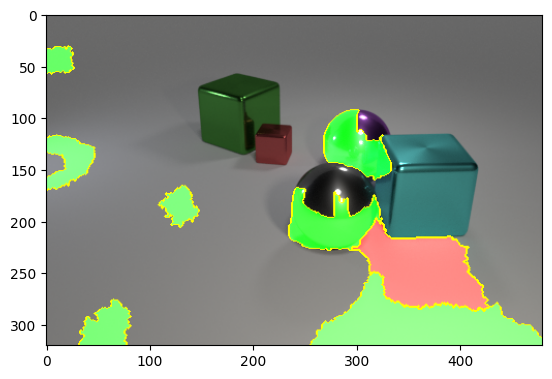

In [28]:
temp, mask = image_exp.get_image_and_mask(image_exp.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)
plt.imsave(f'datasets/lime_results/question_{idx:06d}/lime_image.png', img_boundry2)

In [29]:
print(question)
print('answer: ', class_names[correctansweridx])
print('pred_answer: ', pred_answer(outputs))

There is another object that is the same shape as the gray shiny object; what is its color?
answer:  purple
pred_answer:  purple


### Running LIME on Text Modality

In [30]:
num_samples = 100

def text_predictor_fn(texts):
    normed_image = get_normed(image, info)
    samples = torch.stack([normed_image for i in range(len(texts))]).cuda()
    with torch.no_grad():
      memory_cache = model(samples, texts, encode_and_save=True)
      outputs = model(samples, texts, encode_and_save=False, memory_cache=memory_cache)
      pred_answer_binary_comp = torch.log(torch.sigmoid(1- outputs['pred_answer_binary']) / torch.sigmoid(outputs['pred_answer_binary']))
      probas = torch.cat((outputs['pred_answer_binary'].unsqueeze(0).T, pred_answer_binary_comp.unsqueeze(0).T, outputs['pred_answer_attr'], outputs['pred_answer_reg']), 1)
      return probas.cpu().detach().numpy()

In [31]:
init_params = {
    "class_names": class_names
}
explanation_params = {
    "labels": (correctansweridx,),
    "num_samples": num_samples,
}
text_exp = Lime.explain_text_instance(text_predictor_fn, question, init_params, explanation_params)

In [32]:
text_exp.local_exp

{9: [(13, 9.060379016126225),
  (9, 5.226469490124837),
  (6, 4.347127466928514),
  (3, 4.340922282007698),
  (7, 3.021187650338636),
  (11, 2.048428801894978),
  (4, 1.6176197737116274),
  (5, 1.5307914397823743),
  (12, -1.5175838199144778),
  (10, 1.2839168938471985)]}

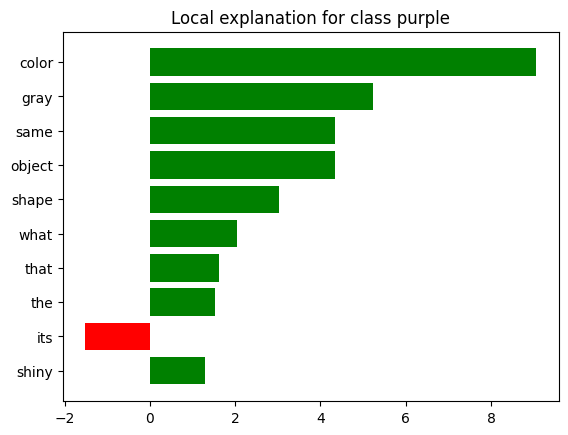

In [33]:
text_fig = text_exp.as_pyplot_figure(label=correctansweridx)

In [34]:
text_fig.savefig(f'datasets/lime_results/question_{idx:06d}/lime_text')

In [35]:
print(question)
print('answer: ', class_names[correctansweridx])
print('pred_answer: ', pred_answer(outputs))

There is another object that is the same shape as the gray shiny object; what is its color?
answer:  purple
pred_answer:  purple


### DIME Preparation

In [36]:
!mkdir datasets/dime

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [37]:
!mkdir datasets/dime/tmp

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [38]:
idxs = [i*1000 for i in range(100)]
imgs = []
questions = []

for idx in idxs:
    question_info = q["questions"][idx]
    image_id = question_info['image_index']
    question = question_info['question']
    question_id = question_info['question_index']
    answer = question_info['answer']
    program = question_info['program']
    img = PIL.Image.open(f'/ssd_scratch/sn/CLEVR_v1.0/images/val/CLEVR_val_{image_id:06d}.png').convert('RGB')
    normed_image = get_normed(img, info)

    imgs.append(normed_image)
    questions.append(question)

In [39]:
storage = torch.zeros(100,100,len(class_names)).cuda()

with torch.no_grad():
  for id1 in idxs:
    for id2 in idxs:
      print("At "+str(id1)+" "+str(id2))
      samples = imgs[id1//1000].unsqueeze(0).cuda()
      captions = [questions[id2//1000]]
      memory_cache = model(samples, captions, encode_and_save=True)
      outputs = model(samples, captions, encode_and_save=False, memory_cache=memory_cache)
      pred_answer_binary_comp = torch.log(torch.sigmoid(1- outputs['pred_answer_binary']) / torch.sigmoid(outputs['pred_answer_binary']))
      probas = torch.cat((outputs['pred_answer_binary'].unsqueeze(0).T, pred_answer_binary_comp.unsqueeze(0).T, outputs['pred_answer_attr'], outputs['pred_answer_reg']), 1)

      storage[id1//1000][id2//1000]=probas

torch.save(storage, 'datasets/dime/storage.pt')

At 0 0
At 0 1000
At 0 2000
At 0 3000
At 0 4000
At 0 5000
At 0 6000
At 0 7000
At 0 8000
At 0 9000
At 0 10000
At 0 11000
At 0 12000
At 0 13000
At 0 14000
At 0 15000
At 0 16000
At 0 17000
At 0 18000
At 0 19000
At 0 20000
At 0 21000
At 0 22000
At 0 23000
At 0 24000
At 0 25000
At 0 26000
At 0 27000
At 0 28000
At 0 29000
At 0 30000
At 0 31000
At 0 32000
At 0 33000
At 0 34000
At 0 35000
At 0 36000
At 0 37000
At 0 38000
At 0 39000
At 0 40000
At 0 41000
At 0 42000
At 0 43000
At 0 44000
At 0 45000
At 0 46000
At 0 47000
At 0 48000
At 0 49000
At 0 50000
At 0 51000
At 0 52000
At 0 53000
At 0 54000
At 0 55000
At 0 56000
At 0 57000
At 0 58000
At 0 59000
At 0 60000
At 0 61000
At 0 62000
At 0 63000
At 0 64000
At 0 65000
At 0 66000
At 0 67000
At 0 68000
At 0 69000
At 0 70000
At 0 71000
At 0 72000
At 0 73000
At 0 74000
At 0 75000
At 0 76000
At 0 77000
At 0 78000
At 0 79000
At 0 80000
At 0 81000
At 0 82000
At 0 83000
At 0 84000
At 0 85000
At 0 86000
At 0 87000
At 0 88000
At 0 89000
At 0 90000
At 0 91000
A

### Running DIME

#### DIME on Image

In [40]:
def imgemape(inps):
  image_paths = []
  rets = []
  for ii in range(len(inps)):
    plt.imsave(f"datasets/dime/tmp/{ii}.jpg", inps[ii])
    image_paths.append(f"datasets/dime/tmp/{ii}.jpg")
    img = PIL.Image.open(image_paths[ii]).convert('RGB')
    normed_image = get_normed(img, info)
    samples = normed_image.unsqueeze(0).cuda()

    with torch.no_grad():
      origs=storage[:,:,correctansweridx]
      newstorage = copy.deepcopy(origs)
      for j in range(100):
        memory_cache = model(samples, captions, encode_and_save=True)
        outputs = model(samples, captions, encode_and_save=False, memory_cache=memory_cache)
        pred_answer_binary_comp = torch.log(torch.sigmoid(1- outputs['pred_answer_binary']) / torch.sigmoid(outputs['pred_answer_binary']))
        probas = torch.cat((outputs['pred_answer_binary'].unsqueeze(0).T, pred_answer_binary_comp.unsqueeze(0).T, outputs['pred_answer_attr'], outputs['pred_answer_reg']), 1)
        newstorage[idx//1000][j]=probas[0][correctansweridx]
      avg0=torch.mean(newstorage, dim=1)
      avg1=torch.mean(newstorage, dim=0)
      avg = torch.mean(avg0)
      uniout = (avg0[idx//1000]+avg1[idx//1000]-avg).item()
      multiout = (newstorage[idx//1000][idx//1000]-uniout).item()
      
      rets.append([uniout,multiout])
  os.system("rm datasets/dime/tmp/*.jpg")
  return np.array(rets)

In [41]:
init_params = {}
explanation_params = {
    "labels": (0,1),
    "hide_color": 0,
    "num_samples": num_samples,
    "batch_size": batch_size
}
image_exp = Lime.explain_image_instance(imgemape, np.array(image), init_params, explanation_params)

  0%|          | 0/100 [00:00<?, ?it/s]

In [42]:
import os
save_path = f'datasets/lime_results/question_{idx:06d}/'
os.makedirs(save_path, exist_ok=True)

Unimodal Output

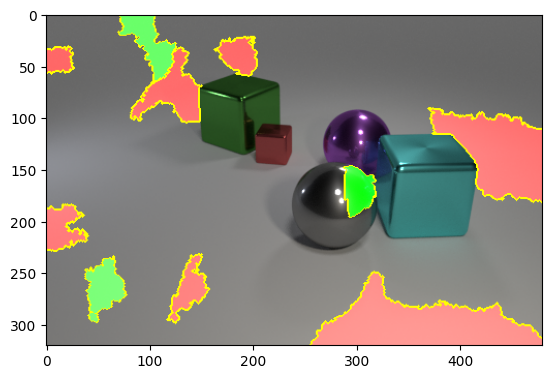

In [43]:
temp, mask = image_exp.get_image_and_mask(0, positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)
plt.imsave(f'datasets/lime_results/question_{idx:06d}/uni_image.png', img_boundry2)

Multimodal Output

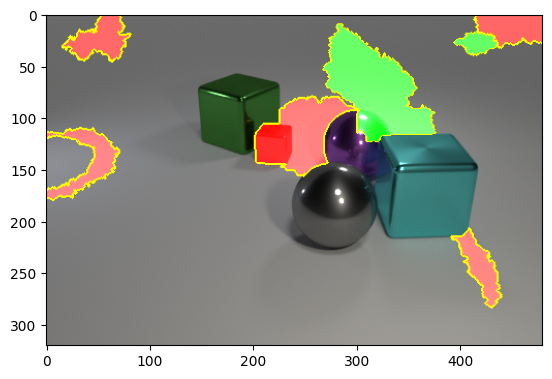

In [44]:
temp, mask = image_exp.get_image_and_mask(1, positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)
plt.imsave(f'datasets/lime_results/question_{idx:06d}/multi_image.png', img_boundry2)

#### DIME on Text

In [45]:
def txtemape(inps):
  rets = []
  for ii in range(len(inps)):
    captions = inps[ii:ii+1]
    with torch.no_grad():
      origs=storage[:,:,correctansweridx]
      newstorage = copy.deepcopy(origs)
      for j in range(100):
        memory_cache = model(samples, captions, encode_and_save=True)
        outputs = model(samples, captions, encode_and_save=False, memory_cache=memory_cache)
        pred_answer_binary_comp = torch.log(torch.sigmoid(1- outputs['pred_answer_binary']) / torch.sigmoid(outputs['pred_answer_binary']))
        probas = torch.cat((outputs['pred_answer_binary'].unsqueeze(0).T, pred_answer_binary_comp.unsqueeze(0).T, outputs['pred_answer_attr'], outputs['pred_answer_reg']), 1)
        newstorage[j][idx//1000]=probas[0][correctansweridx]
      avg0=torch.mean(newstorage, dim=1)
      avg1=torch.mean(newstorage, dim=0)
      avg = torch.mean(avg0)
      uniout = (avg0[idx//1000]+avg1[idx//1000]-avg).item()
      multiout = (newstorage[idx//1000][idx//1000]-uniout).item()
      
      rets.append([uniout,multiout])
      
  return np.array(rets)

In [46]:
init_params = {}
explanation_params = {
    "labels": (0,1),
    "num_samples":100
}
text_exp = Lime.explain_text_instance(txtemape, question, init_params, explanation_params)

Unimodal Output

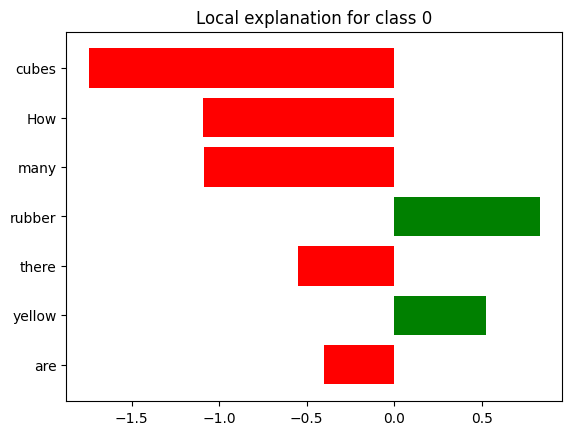

In [47]:
text_fig = text_exp.as_pyplot_figure(label=0)

In [48]:
text_fig.savefig(f'datasets/lime_results/question_{idx:06d}/uni_text.png')

Multimodal Output

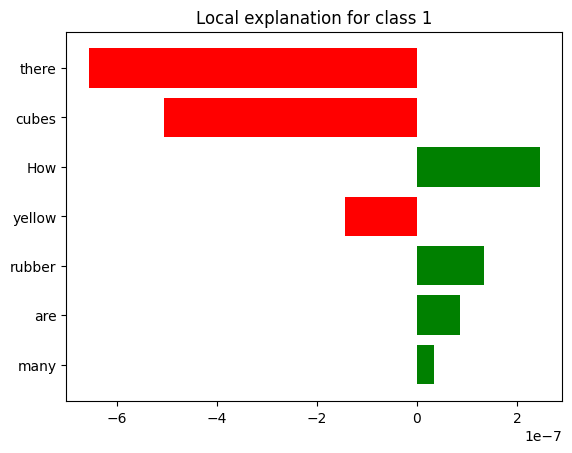

In [49]:
text_fig = text_exp.as_pyplot_figure(label=1)

In [50]:
text_fig.savefig(f'datasets/lime_results/question_{idx:06d}/multi_text.png')